In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hfnet.datasets.sfm import Sfm
from hfnet.evaluation.loaders import sift_loader, export_loader, fast_loader, harris_loader
from hfnet.evaluation.local_descriptors import evaluate
from hfnet.utils import tools

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
config = {
    'sequences': ['british_museum', 'london_bridge', 'milan_cathedral','mount_rushmore', 
                  'piazza_san_marco', 'reichstag', 'st_pauls_cathedral',
                  'florence_cathedral_side', 'lincoln_memorial_statue', 'sagrada_familia'],
    'make_pairs': True, 'shuffle': True, 'pair_thresh': 0.4, 'max_num_pairs': 50,
    'preprocessing': {'upright': True},
}
dataset = Sfm(**config)

[01/10/2019 15:07:58 INFO] SfM sequence british_museum contains 50 pairs
[01/10/2019 15:08:01 INFO] SfM sequence florence_cathedral_side contains 50 pairs
[01/10/2019 15:08:26 INFO] SfM sequence lincoln_memorial_statue contains 50 pairs
[01/10/2019 15:08:46 INFO] SfM sequence london_bridge contains 50 pairs
[01/10/2019 15:08:50 INFO] SfM sequence milan_cathedral contains 50 pairs
[01/10/2019 15:08:55 INFO] SfM sequence mount_rushmore contains 50 pairs
[01/10/2019 15:09:03 INFO] SfM sequence piazza_san_marco contains 50 pairs
[01/10/2019 15:09:04 INFO] No EXIF data for sequence reichstag
[01/10/2019 15:09:04 INFO] SfM sequence reichstag contains 50 pairs
[01/10/2019 15:09:19 INFO] SfM sequence sagrada_familia contains 50 pairs
[01/10/2019 15:09:38 INFO] SfM sequence st_pauls_cathedral contains 50 pairs


In [29]:
all_configs = {
    'sift': {
        'predictor': sift_loader,
        'root': True,
    },
    'superpoint': {
        'experiment': 'super_point_pytorch/sfm_upright',
        'predictor': export_loader,
        'do_nms': True,
        'nms_thresh': 4,
        'remove_borders': 4,
        'binarize': False,
    },
    'superpoint_harris-kpts': {
        'experiment': 'super_point_pytorch/sfm_upright',
        'predictor': export_loader,
        'keypoint_predictor': harris_loader,
        'keypoint_config': {
                'do_nms': True,
                'nms_thresh': 4,
        },
        'binarize': False,
    },
    'doap': {
        'experiment': 'doap/sfm_upright_hpatches_ST-dense',
        'predictor': export_loader,
        'keypoint_predictor': export_loader,
        'keypoint_config': {
            'experiment': 'super_point_pytorch/sfm_upright',
            'do_nms': True,
            'nms_thresh': 4,
            'remove_borders': 4,
        },
        'binarize': False,
    },  
    'netvlad_conv3-3': {
        'experiment': 'netvlad/sfm_upright',
        'predictor': export_loader,
        'keypoint_predictor': export_loader,
        'keypoint_config': {
            'experiment': 'super_point_pytorch/sfm_upright',
            'do_nms': True,
            'nms_thresh': 4,
            'remove_borders': 4,
        },
        'binarize': False,
    },
    'lfnet': {
        'experiment': 'lfnet/sfm_upright_kpts-1000',
        'predictor': export_loader,
    },
}
eval_config = {
    'num_features': 1000,
    'do_ratio_test': True,
    'correct_match_thresh': 5,
    'correct_trans_thresh': 3,
    'correct_rot_thresh': 1,
}

In [ ]:
methods = ['sift', 'lfnet', 'superpoint', 'superpoint_harris-kpts', 'doap', 'netvlad_conv3-3']
configs = {m: all_configs[m] for m in methods}
pose_recalls, nn_pr = {}, {}
for method, config in configs.items():
    config = tools.dict_update(config, eval_config)
    data_iter = dataset.get_test_set()
    metrics, nn_precision, nn_recall, distances, pose_recall = evaluate(data_iter, config, is_2d=False)
    
    print('> {}'.format(method))
    for k, v in metrics.items():
        print('{:<25} {:.3f}'.format(k, v))
    print(config)
    
    pose_recalls[method] = pose_recall
    nn_pr[method] = (nn_precision, nn_recall, distances)

In [30]:
# NMS=4, N=1000, t_thresh=3, rot_thresh=1, match_thresh=5, all, upright

500it [03:26,  3.15it/s]
0it [00:00, ?it/s]

> sift
average_num_keypoints     1000.000
matching_score            0.199
pose_correctness          0.700
mAP                       0.236
{'predictor': <function sift_loader at 0x2aab18ef09d8>, 'root': True, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


500it [01:31,  7.01it/s]
0it [00:00, ?it/s]

> lfnet
average_num_keypoints     1000.000
matching_score            0.221
pose_correctness          0.676
mAP                       0.207
{'experiment': 'lfnet/colmap_upright_kpts-1000', 'predictor': <function export_loader at 0x2aab1b1af620>, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


500it [02:30,  3.42it/s]
0it [00:00, ?it/s]

> superpoint
average_num_keypoints     825.976
matching_score            0.418
pose_correctness          0.794
mAP                       0.488
{'experiment': 'super_point_pytorch/colmap_upright', 'predictor': <function export_loader at 0x2aab1b1af620>, 'do_nms': True, 'nms_thresh': 4, 'remove_borders': 4, 'binarize': False, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


500it [03:26,  3.12it/s]
0it [00:00, ?it/s]

> superpoint_harris-kpts
average_num_keypoints     978.754
matching_score            0.404
pose_correctness          0.684
mAP                       0.397
{'experiment': 'super_point_pytorch/colmap_upright', 'predictor': <function export_loader at 0x2aab1b1af620>, 'keypoint_predictor': <function harris_loader at 0x2aab1b1af598>, 'keypoint_config': {'do_nms': True, 'nms_thresh': 4, 'keypoint_predictor': None}, 'binarize': False, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


500it [03:13,  2.90it/s]
0it [00:00, ?it/s]

> doap
average_num_keypoints     825.976
matching_score            0.448
pose_correctness          0.838
mAP                       0.554
{'experiment': 'doap/colmap_upright_hpatches_ST-dense', 'predictor': <function export_loader at 0x2aab1b1af620>, 'keypoint_predictor': <function export_loader at 0x2aab1b1af620>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_upright', 'do_nms': True, 'nms_thresh': 4, 'remove_borders': 4, 'keypoint_predictor': None}, 'binarize': False, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


420it [04:11,  2.19it/s]/cluster/home/psarlin/HF-Net/hfnet/evaluation/utils/misc.py:15: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.abs(np.arccos(cos)))
500it [04:52,  1.86it/s]

> netvlad_conv3-3
average_num_keypoints     825.976
matching_score            0.374
pose_correctness          0.800
mAP                       0.423
{'experiment': 'netvlad/colmap_upright', 'predictor': <function export_loader at 0x2aab1b1af620>, 'keypoint_predictor': <function export_loader at 0x2aab1b1af620>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_upright', 'do_nms': True, 'nms_thresh': 4, 'remove_borders': 4, 'keypoint_predictor': None}, 'binarize': False, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


In [23]:
# NMS=4, N=1000, t_thresh=3, rot_thresh=1, match_thresh=5, all, no-upright

500it [03:38,  2.76it/s]
0it [00:00, ?it/s]

> sift
average_num_keypoints     1000.000
matching_score            0.199
pose_correctness          0.706
mAP                       0.236
{'predictor': <function sift_loader at 0x2aab18ef09d8>, 'root': True, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


500it [01:30,  7.33it/s]
0it [00:00, ?it/s]

> lfnet
average_num_keypoints     1000.000
matching_score            0.217
pose_correctness          0.664
mAP                       0.199
{'experiment': 'lfnet/colmap_all_kpts-1000', 'predictor': <function export_loader at 0x2aab1b1af620>, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


500it [02:21,  3.76it/s]
0it [00:00, ?it/s]

> superpoint
average_num_keypoints     825.813
matching_score            0.390
pose_correctness          0.738
mAP                       0.450
{'experiment': 'super_point_pytorch/colmap', 'predictor': <function export_loader at 0x2aab1b1af620>, 'do_nms': True, 'nms_thresh': 4, 'remove_borders': 4, 'binarize': False, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


500it [03:30,  3.25it/s]
0it [00:00, ?it/s]

> superpoint_harris-kpts
average_num_keypoints     978.754
matching_score            0.374
pose_correctness          0.628
mAP                       0.360
{'experiment': 'super_point_pytorch/colmap', 'predictor': <function export_loader at 0x2aab1b1af620>, 'keypoint_predictor': <function harris_loader at 0x2aab1b1af598>, 'keypoint_config': {'do_nms': True, 'nms_thresh': 4, 'keypoint_predictor': None}, 'binarize': False, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


500it [03:05,  2.71it/s]
0it [00:00, ?it/s]

> doap
average_num_keypoints     825.813
matching_score            0.419
pose_correctness          0.782
mAP                       0.514
{'experiment': 'doap/colmap_hpatches_ST-dense', 'predictor': <function export_loader at 0x2aab1b1af620>, 'keypoint_predictor': <function export_loader at 0x2aab1b1af620>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap', 'do_nms': True, 'nms_thresh': 4, 'remove_borders': 4, 'keypoint_predictor': None}, 'binarize': False, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


420it [04:02,  2.13it/s]/cluster/home/psarlin/HF-Net/hfnet/evaluation/utils/misc.py:15: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.abs(np.arccos(cos)))
500it [04:45,  1.77it/s]

> netvlad_conv3-3
average_num_keypoints     825.813
matching_score            0.349
pose_correctness          0.748
mAP                       0.390
{'experiment': 'netvlad/colmap', 'predictor': <function export_loader at 0x2aab1b1af620>, 'keypoint_predictor': <function export_loader at 0x2aab1b1af620>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap', 'do_nms': True, 'nms_thresh': 4, 'remove_borders': 4, 'keypoint_predictor': None}, 'binarize': False, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 3, 'correct_rot_thresh': 1}


  translation             sift             0.5 : 0.44    1  : 0.62    4  : 0.84 
  translation             lfnet            0.5 : 0.39    1  : 0.59    4  : 0.83 
  translation          superpoint          0.5 : 0.48    1  : 0.68    4  : 0.91 
  translation    superpoint_harris-kpts    0.5 : 0.40    1  : 0.55    4  : 0.88 
  translation             doap             0.5 : 0.51    1  : 0.73    4  : 0.93 
  translation        netvlad_conv3-3       0.5 : 0.50    1  : 0.70    4  : 0.91 
   rotation               sift            0.25 : 0.39    1  : 0.72   1.5 : 0.79 
   rotation               lfnet           0.25 : 0.35    1  : 0.69   1.5 : 0.76 
   rotation            superpoint         0.25 : 0.42    1  : 0.81   1.5 : 0.88 
   rotation      superpoint_harris-kpts   0.25 : 0.26    1  : 0.71   1.5 : 0.81 
   rotation               doap            0.25 : 0.44    1  : 0.85   1.5 : 0.89 
   rotation          netvlad_conv3-3      0.25 : 0.46    1  : 0.81   1.5 : 0.85 


/cluster/home/psarlin/HF-Net/env_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


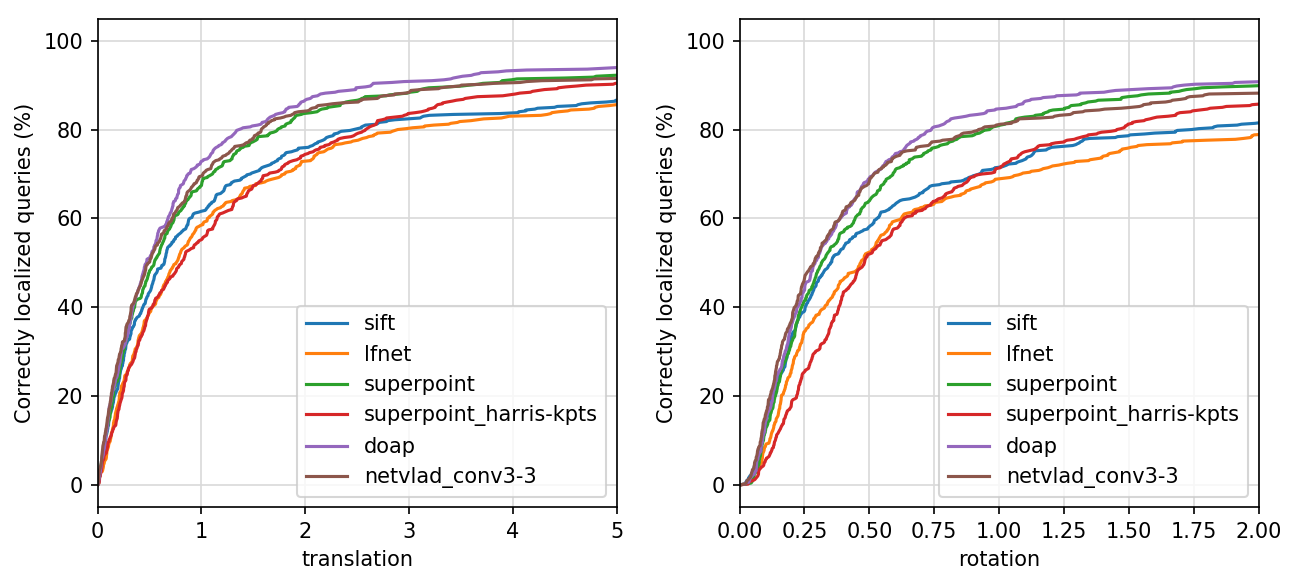

In [31]:
error_names = list(list(pose_recalls.values())[0].keys())
expers = list(pose_recalls.keys())
lim = {'translation': 5, 'rotation': 2}
thresh = {'translation': [0.5, 1, 4], 'rotation': [0.25, 1, 1.5]}

f, axes = plt.subplots(1, len(error_names), figsize=(8, 4), dpi=150)
for error_name, ax in zip(error_names, axes):
    for exper in expers:
        steps, recall = pose_recalls[exper][error_name]
        ax.set_xlim([0, lim[error_name]])
        ax.plot(steps, recall*100, label=exper);
        
        s = f'{error_name:^15} {exper:^25}'
        s += ''.join([f' {t:^5}: {recall[np.where(steps>t)[0].min()]:.2f} ' for t in thresh[error_name]])
        print(s)
        
    ax.grid(color=[0.85]*3);
    ax.set_xlabel(error_name);
    ax.set_ylabel('Correctly localized queries (%)');
    ax.legend(loc=4); 
plt.tight_layout()
plt.gcf().subplots_adjust(left=0);

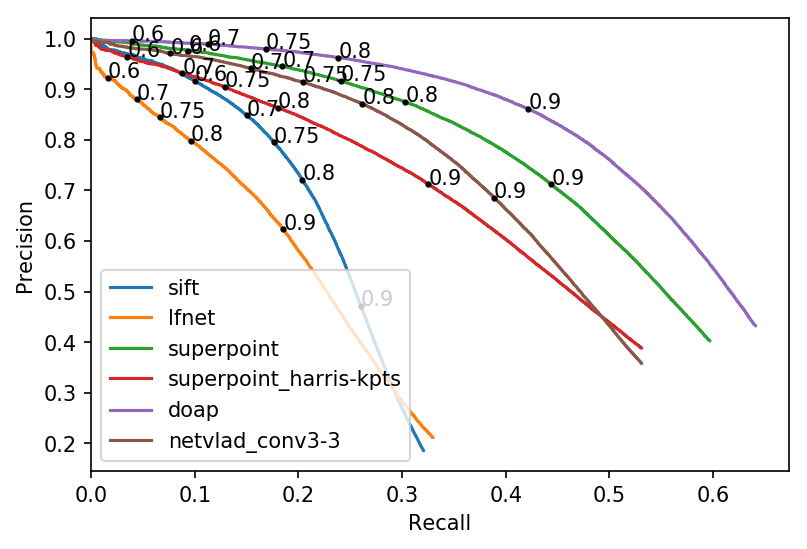

In [32]:
match_thresh = [0.9, 0.8, 0.75, 0.7, 0.6]
plt.figure(dpi=150, figsize=(6, 4));
for exper, (precision, recall, distances) in nn_pr.items():
    plt.plot(recall, precision, label=exper);

    for t in match_thresh:
        op_idx = np.min(np.where(distances > t))
        plt.plot(recall[op_idx], precision[op_idx], marker='o', color='k', markersize=2)
        plt.annotate(str(t), xy=(recall[op_idx], precision[op_idx]))
        
plt.xlim(0, None)
plt.xlabel('Recall'), plt.ylabel('Precision'); plt.legend(loc=3);